# 実践コンピュータビジョン

[実践 コンピュータビジョン](https://www.oreilly.co.jp/books/9784873116075/)  
[Multiple View Geometry in Computer Vision](https://www.amazon.co.jp/dp/0521540518)(以下、MVGCVと呼ぶ) 

演習ノート

# 3. 画像間の写像

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path    
import sys
sys.path.append("../")
from impro import impro,detection,homography

## 3.1 ホモグラフィー

>ホモグラフィーは、ある平面から別の平面へ写像する2Dの射影変換です。

### 同次座標
2次元座標上の点は$(x,y)$と2つの数の組で表せるが、もう1つ座標を加えて、$(x,y,1)$として表す。このような座標のことをを同次座標(homogeneous coordinate)と呼ぶ

### 同次座標の変換
座標$(x,y)$の点を座標変換して、さらに$(t_x,t_y)$平行移動する場合を考える。
$$
{\begin{cases}
x' = a_1x+a_2y+t_x \\
y' = a_3x+a_4y+t_y
\end{cases}\tag{2}
}
$$

同次座標を用いればこれを行列の積で表すことができる。
$$
\begin{pmatrix}
x' \\
y' \\
1
\end{pmatrix}=
\begin{pmatrix}
a_1 & a_2 & t_x \\
a_3 & a_4 & t_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
$$

### アフィン変換
上で述べたように、任意の線形変換と平行移動の組み合わせは次のように表せる。
$$
\begin{pmatrix}
x' \\
y' \\
1
\end{pmatrix}=
\begin{pmatrix}
a_1 & a_2 & t_x \\
a_3 & a_4 & t_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
$$
このような変換行列の$2\times3$の部分を使った変換をアフィン変換（affine transformation）と呼ぶ。

### 射影変換
アフィン変換は$2\times3$の部分しか使っていないが、$3\times3$全てを使うとより一般的な変換を表現できる。
$$
\begin{pmatrix}
x' \\
y' \\
w'
\end{pmatrix}=
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
w
\end{pmatrix}
$$
$$
\boldsymbol{x}'=H\boldsymbol{x}
$$
このような変換を射影変換（projective transformation）と呼ぶ。透視変換（perspective transformation）やホモグラフィ変換（homography transformation: 平面射影変換）とも呼ばれる。

同次座標、射影平面、アフィン変換、射影変換について詳しくは以下を参照  
- [完全に理解するアフィン変換 - Qiita](https://qiita.com/koshian2/items/c133e2e10c261b8646bf)  
- [Python, OpenCVで幾何変換（アフィン変換・射影変換など） | note.nkmk.me](https://note.nkmk.me/python-opencv-warp-affine-perspective/)
- [射影平面をいくつかの方法で図示してみる - あおいろメモ](https://solkul.hatenablog.com/entry/2021/01/15/113702)  

### 回転
OpenCVでは、画像の左上を原点$(0,0)$とし、右方向を$x$プラス方向、下方向を$y$プラス方向に取る。数学のxy座標系とは異なるので注意。  
一方、`cv2.getRotationMatrix2D`は数学でのxy座標系と同様、反時計回りを正に取る。  
従って、数学では回転行列が
$$
\begin{pmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{pmatrix}
$$
であるのに対し、OpenCVでは
$$
\begin{pmatrix}
\cos\theta & \sin\theta \\
- \sin\theta & \cos\theta
\end{pmatrix}
$$
となる。
詳しくはドキュメント参照  
[Geometric Image Transformations — opencv v2.2 documentation](http://opencv.jp/opencv-2.2_org/py/imgproc_geometric_image_transformations.html#getrotationmatrix2d)

### 正規化と同次座標への変換

In [41]:
# 自作のimpro.homographyに3つの組の最後の座標で割り、正規化する関数を実装
points=np.arange(12).reshape(3,-1)
points

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [42]:
homography.normalize(points)

array([[0.        , 0.11111111, 0.2       , 0.27272727],
       [0.5       , 0.55555556, 0.6       , 0.63636364],
       [1.        , 1.        , 1.        , 1.        ]])

In [43]:
# 同次座標への変換
points=np.arange(12).reshape(2,-1)
points

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

In [61]:
homography.make_homog(points)

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])

### 3.1.1 DLTアルゴリズム
射影変換はホモグラフィー行列$H$を使って次のように表すことができる
$$
\begin{pmatrix}
x' \\
y' \\
w'
\end{pmatrix}=
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
w
\end{pmatrix}
$$
$$
\boldsymbol{x}'=H\boldsymbol{x}
$$

ある点$(x,y)$から$(x',y')$へ変換する$H$を求めるのがDirect Linear Transformation(DLT)アルゴリズムである。詳しい導出は[Multiple View Geometry in Computer Vision](https://www.amazon.co.jp/dp/0521540518)の4.1(p88)を参照。以下はその概要と、補足を記す。

$i=0,1,\ldots$として、いくつかの点$\boldsymbol{x}_i$が行列$H$による射影変換で$\boldsymbol{x}'_i$へ移るとする。DLTアルゴリズムではこの$H$を、$\boldsymbol{x}'$同士の外積$\boldsymbol{x}'\times H\boldsymbol{x}$が0であることを用いて導出する。
$$
\boldsymbol{x}'_i\times H\boldsymbol{x}_i=
\begin{pmatrix}
y'_i\boldsymbol{h}^{3T}\boldsymbol{x}_i-w'_i\boldsymbol{h}^{2T}\boldsymbol{x}_i \\
w'_i\boldsymbol{h}^{1T}\boldsymbol{x}_i-x'_i\boldsymbol{h}^{3T}\boldsymbol{x}_i \\
x'_i\boldsymbol{h}^{2T}\boldsymbol{x}_i-y'_i\boldsymbol{h}^{1T}\boldsymbol{x}_i
\end{pmatrix}
=\boldsymbol{0}
$$
これを変形することで、$A\boldsymbol{h}=\boldsymbol{0}$という式になる。

#### 線形代数のIm:像、Ker:核との関係
MVGCVのp90では以下のように述べている。
>変換前、変換後の点の対応1つにつき、2つの独立な線形方程式が得られる。もしそのような対応が4点分あったら、8つの独立な線形方程式が得られる。そうすると、$A$のランクが8となるので、$\boldsymbol{h}$の解は非ゼロの1次元ベクトル空間になる。これによって$\boldsymbol{h}$はスケールの違いを除いて一意に決まる。


これについて捕捉する。$\boldsymbol{h}=\mathrm{Ker}A$(Aのカーネル)であるので、もともとの$h$がとりうるベクトル空間を$V$とすると
$$
\mathrm{dim}V=\mathrm{rank}A+\mathrm{dim}\boldsymbol{h}
$$
とできる。今、8つの独立な線形方程式が得られ、$\mathrm{rank}A=8$となり、$\mathrm{dim}V=9$なので$\mathrm{dim}\boldsymbol{h}=1$となる、つまり$\boldsymbol{h}$は行列の固有ベクトルのように大きさが任意の向きが決まったベクトルとなるということである。なお、$\mathrm{dim}V=\mathrm{rank}A+\mathrm{dim}\boldsymbol{h}$については以下を参照


[線形写像の次元定理dim V = rank f + dim ker fの証明 | 数学の景色](https://mathlandscape.com/rank-ker-dim/)

#### 特異値分解 singular value decomposition(SVD)との関係
一般的に$h$を求めるには$A^TA$の最小の固有値に対応する固有ベクトルが$h$となる。具体的には$A$を特異値分解し、
$$
A=U\Sigma V^T
$$
この右特異ベクトル$V^T$の8行目のベクトルが最適な$h$となる。  
この導出に利用する線形方程式の解法についてはMVGCVのA.5(p588)や日本語の場合次の資料を参照。  
- [【解説】 一般逆行列](https://www.slideshare.net/wosugi/ss-79624897)
- [特異値分解を詳しく解説 - Qiita](https://qiita.com/kidaufo/items/0f3da4ca4e19dc0e987e)

[特異値分解を詳しく解説 - Qiita](https://qiita.com/kidaufo/items/0f3da4ca4e19dc0e987e)で述べているように、numpyの`np.linalg.svd`場合、$m\times
n$でランクが$r<m,n$の行列$A$を特異値分解すると、次の図で示されるような分解のされ方をする。
![img](figures/01SVD_python.png)

DLTアルゴリズムでは$A$は$m\times9$なので、次の図のようになる。そして$V^T$の8行目が最適な$h$となる。(条件を満たすホモグラフィーが存在する4点以上の厳密な座標の対応が与えられたときには$A$はランク8、つまり$r=8$となるが、そうでない場合は$r\neq8$となりうる)
![img](figures/02SVD_DLT.png)

[実践 コンピュータビジョン](https://www.oreilly.co.jp/books/9784873116075/)のp57のサンプルコードでは次のように$V^T$の8行目を取得し、$H$としている。
```python
U,S,V = np.linalg.svd(mat_A)
H = V[8].reshape((3,3))
```

#### 自作モジュールでの実装
`impro.homography.H_from_points`に実装してある。  
入力は同次座標でなければならない

In [2]:
src=np.array(
    [
        [0,0],
        [0,1],
        [1,0],
        [1,1]
    ],
    np.float32).T
dest=src*10
dest

array([[ 0.,  0., 10., 10.],
       [ 0., 10.,  0., 10.]], dtype=float32)

In [3]:
src_homo=homography.make_homog(src)
dest_homo=homography.make_homog(dest)
dest_homo

array([[ 0.,  0., 10., 10.],
       [ 0., 10.,  0., 10.],
       [ 1.,  1.,  1.,  1.]])

In [16]:
H_mat=homography.H_from_points(src_homo,dest_homo)
H_mat

array([[ 1.00000000e+01, -1.92296269e-15,  1.92296269e-15],
       [-3.77125791e-16,  1.00000000e+01, -1.15377761e-15],
       [-2.88444403e-16,  1.92296268e-16,  1.00000000e+00]])

### 3.1.2　アフィン変換
アフィン変換については上で述べ、また、自作モジュールを使わずopenCVを使う方法を次でまとめるのでスキップ

### openCVを使う

- `cv2.getAffinTransform`:3つの点の対応からアフィン変換を求める
- `cv2.warpAffine`:アフィン変換を画像に適用
- `cv2.getPerspectiveTransform`:4つの点の対応から射影変換を求める
- `cv2.findHomography`:5つ以上の点の対応から最適な射影変換を推定する
- `cv2.warpPerspective`:射影変換を画像に適用

詳しい使い方は以下参照

- [完全に理解するアフィン変換 - Qiita](https://qiita.com/koshian2/items/c133e2e10c261b8646bf)  
- [Python, OpenCVで幾何変換（アフィン変換・射影変換など） | note.nkmk.me](https://note.nkmk.me/python-opencv-warp-affine-perspective/)

## 3.2 画像の変形

ドキュメント:
[scipy.ndimage.affine_transform — SciPy v1.9.1 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.affine_transform.html)  

ドキュメントに"This does ‘pull’ (or ‘backward’) resampling"と書いてあるように、`scipy.ndimages.affine_transform`は移動後から移動前へのアフィン変換の行列を引数として代入する。opencvとは逆なので注意

この演習ノートでは`cv2.warpAffine`を主に用いることにする。

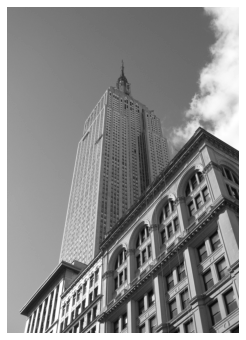

In [3]:
# 画像を読み込む
im_path=Path("resources/data/empire.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
impro.imshow(im_gray)

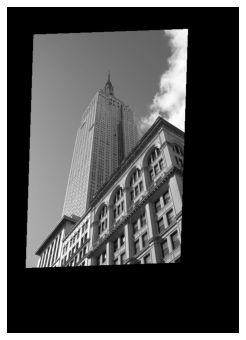

In [4]:
# `scipy.ndimage.affin_transform`の場合
from scipy import ndimage

H_mat = np.array([[1.4,0.05,-100],[0.05,1.5,-100],[0,0,1]])
im2 =ndimage.affine_transform(im_gray,H_mat[:2,:2],(-100,-100))
impro.imshow(im2)

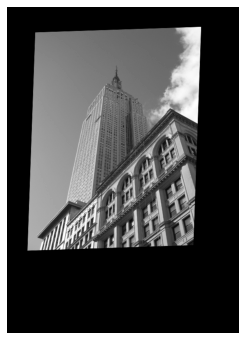

In [9]:
# `cv2.warpAffine`の場合
h, w = im_gray.shape[:2]
# scipy.ndimages.affine_transformとcv2.warpAffineでは
# 用いる行列の変換の方向が逆なので注意
H_mat_inv=np.linalg.inv(H_mat)
im3 =cv2.warpAffine(im_gray,H_mat_inv[:2,:],(w,h))
impro.imshow(im3)

### 3.2.1 画像の中の画像

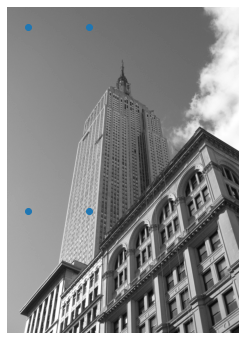

In [10]:
# 画像を読み込む
im_path=Path("resources/data/empire.jpg")
im=cv2.imread(str(im_path))
im1=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
fig=impro.imshow(im1,return_fig=True)
# 画像を移動させる座標
tp_xy=np.array([[50,200,200,50],[50,50,500,500]])
ax=fig.axes[0]
ax.scatter(tp_xy[0,:],tp_xy[1,:])

### scipyによる画像の変形

In [11]:
# 元の座標
# 左上から時計回りとする
m,n = im1.shape[:2]
fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
fp

array([[  0, 800, 800,   0],
       [  0,   0, 569, 569],
       [  1,   1,   1,   1]])

In [12]:
# 移動後の座標
tp=homography.make_homog(tp_xy)
tp

array([[ 50., 200., 200.,  50.],
       [ 50.,  50., 500., 500.],
       [  1.,   1.,   1.,   1.]])

In [13]:
# 移動後の座標から、元の座標への変換を求める
H_mat_inverse=homography.H_from_points(tp,fp)
H_mat_inverse

array([[ 5.33333333e+00,  1.91922152e-15, -2.66666667e+02],
       [ 3.67176028e-15,  1.26444444e+00, -6.32222222e+01],
       [ 9.59610760e-18,  1.59935127e-18,  1.00000000e+00]])

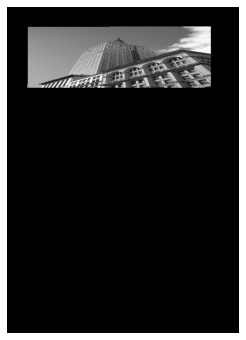

In [14]:
# scipy.ndimages.affine_transformで画像を移動
im_ndimage=ndimage.affine_transform(
    im1,
    H_mat_inverse[:2,:2],
    (H_mat_inverse[0,2],H_mat_inverse[1,2]),
    im1.shape[:2])
impro.imshow(im_ndimage)

### 座標の扱いについて
上の結果はx,y座標がおかしくなっている。

numpyのarrayを画像として扱う際、1次元目と2次元目をどう座標に割り当てるかについて、以下のように推測できる
- matplotは(y,x)
- openCVも(y,x)
- scipyのndimageは**(x,y)**になっている

#### openCVの場合

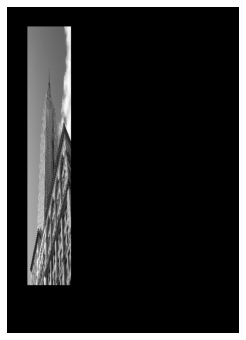

In [15]:
# 元の座標から、移動後の座標への変換を求める
H_mat=homography.H_from_points(fp,tp)
h, w = im_gray.shape[:2]
im_warped=cv2.warpAffine(im1,H_mat[:2,:],(w,h))
impro.imshow(im_warped)

以下はスキップ
- 3.2.1 画像の中の画像
- 3.2.2 分割アフィンワーピング
- 3.2.3 画像の位置合わせ

## 3.3 パノラマの作成
### 3.3.1 RANSAC

>RANSACはRANdom SAmple Consensusの略で、外れ値を含むデータにモデルを当てはめる反
復法です。例えば点の集合に対してホモグラフィーのモデルを仮定し、データにはそのモデルによっ
て記述可能な点と、モデルが当てはまらない外れ値が含まれていると考えます

以下記事も参考

[一目で分かるRANSAC - Qiita](https://qiita.com/kazetof/items/b3439d9258cc85ddf66b)  
[RANSAC | technical-note](https://hkawabata.github.io/technical-note/note/ML/ransac.html)  

>1. 全データサンプル$n$件のうち $m$件をランダムに抽出（非復元抽出）
>1. 抽出したサンプルを使い、仮モデル $C_1$を学習
>1. 全データサンプルにおいて、$C_1$による予測値と実際のデータとの差が$t$以下であるものを全て選び「正常値」とする。正常値が少なすぎる（閾値を決めておく）場合は1に戻る
>1. 全ての正常値を用いてモデル$C_2$を学習
>1. 全ての正常値に対して、平均二乗誤差などの指標を用いて $C_2$の性能を評価
>1. 1〜5を $k$回繰り返し、得られた $C_2$のうち最も性能の良いモデルを最終結果とする


#### 超幾何分布について
上で$m$件非復元抽出しているが、この時の確率は超幾何分布で求められる。また超幾何分布は全サンプル数が多くなると、二項分布に近似できる。
(参考:[超幾何分布 - Qiita](https://qiita.com/mtakayuki/items/6db9588524691c378304))

全データサンプル$n$件のうち外れ値の割合を$r_{out}$、さらに抽出件数$m$がデータ数$n$よりも十分小さい($m\ll n$)とする。この時$m$件抽出して、すべて外れ値でない(つまりinlier)である確率は次のようになる。
$$
\frac{{}_{n(1-r_{out})} C_m}{{}_n C_m}\approx\left[\frac{n(1-r_{out})}{n}\right]^m=(1-r_{out})^m
$$

さらに詳しくは上記記事参照

#### RANSACの実装
RANSACはいくつかのライブラリに実装されている。
- [RANSAC — SciPy Cookbook documentation](https://scipy-cookbook.readthedocs.io/items/RANSAC.html):フルスクラッチな実装。教科書はこれを使っている
    - fitとget_errorというメソッドが存在するモデルクラスを用意する必要がある
- scikit-learnの`sklearn.linear_model.RANSACRegressor`
    -  estimatorには`fit`、`score`、`predict`の各メソッドがあるモデルクラスを入れる。Noneの場合はlinearRegressorが使われる
- openCVでホモグラフィー行列を推定する`cv2.findHomography`で引数の`method`に`CV2.RANSAC`を指定することでopenCVに実装されたransacを利用可能

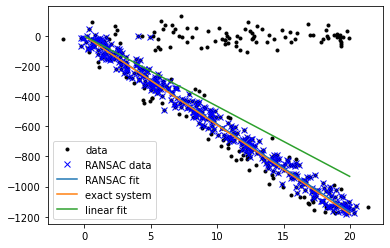

In [102]:
# 教科書のコード
from impro import ransac
np.random.seed(0)
ransac.test()

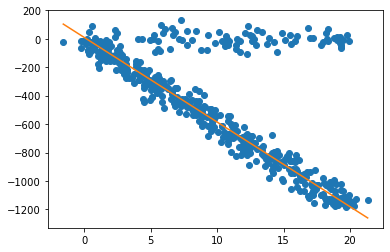

In [104]:
# sklearn.linear_model.RANSACRegressorを使用した場合
from sklearn.linear_model import RANSACRegressor

# impro.ransc.pyと同様に、ノイズの載った点を生成
np.random.seed(0)
n_samples = 500
n_inputs = 1
n_outputs = 1
A_exact = 20*np.random.random((n_samples,n_inputs) )
perfect_fit = 60*np.random.normal(size=(n_inputs,n_outputs) ) # the model
B_exact = np.dot(A_exact,perfect_fit)
assert B_exact.shape == (n_samples,n_outputs)

# add a little gaussian noise (linear least squares alone should handle this well)
A_noisy = A_exact + np.random.normal(size=A_exact.shape )
B_noisy = B_exact + np.random.normal(size=B_exact.shape )

n_outliers = 100
all_idxs = np.arange( A_noisy.shape[0] )
np.random.shuffle(all_idxs)
outlier_idxs = all_idxs[:n_outliers]
non_outlier_idxs = all_idxs[n_outliers:]
A_noisy[outlier_idxs] =  20*np.random.random((n_outliers,n_inputs) )
B_noisy[outlier_idxs] = 50*np.random.normal(size=(n_outliers,n_outputs) )

# ransac regressorで、回帰、予測する
rans_reg=RANSACRegressor()
rans_reg.fit(A_noisy,B_noisy)

A_maxmin=np.array([min(A_noisy),max(A_noisy)])
B_maxmin_pred=rans_reg.predict(A_maxmin)

# 結果を図示する
plt.scatter(A_noisy,B_noisy)
plt.plot(A_maxmin,B_maxmin_pred,'C1')

### 3.3.2 ロバストなホモグラフィー推定

上で述べたフルスクラッチのRANSACを用いて、オーバーラップした画像同士を繋げるホモグラフィーをロバストに推定する。教科書と同様、fitとget_errorというメソッドのあるホモグラフィー用のモデルクラスを用いる。しかし、今回、教科書とは違い、SIFT特徴量記述子はopenCVのものを用いているので、マッチング結果から同次座標を計算する部分は自分で書いた。

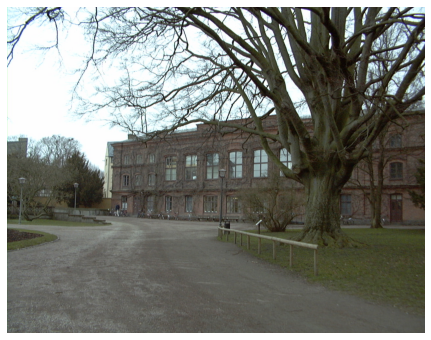

In [2]:
# 5枚の画像を読み込む
imname = ['Univ'+str(i+1)+'.jpg' for i in range(5)]

im_list=[]
for i in range(5):
    im_path_str=str(Path("resources/data/")/imname[i])
    im_list.append(cv2.imread(im_path_str))

impro.imshow(im_list[0])

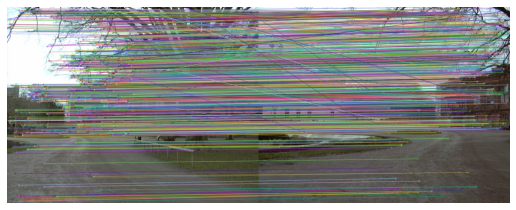

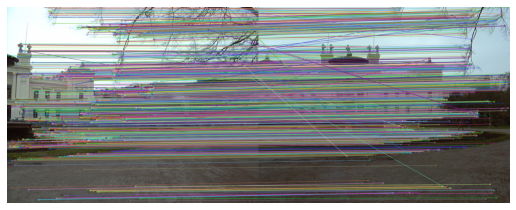

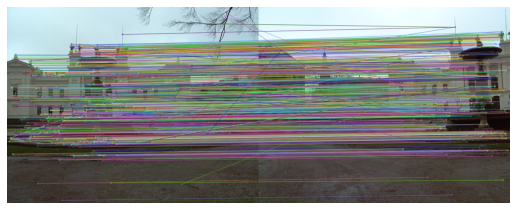

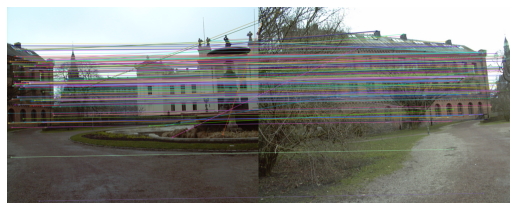

In [4]:
# 前の画像と次の画像の特徴点をSIFTで検出し、マッチングの結果を表示する
for i in range(4):
    kp1,kp2,matches,img3=detection.sift_matching(im_list[i],im_list[i+1],draw_result=True)
    impro.imshow(img3)

In [9]:
# 0枚目と1枚目をマッチングする
kp1,kp2,matches=detection.sift_matching(im_list[0],im_list[1],draw_result=False)

# それぞれの座標を同次座標に変換する
fp_list=[]
tp_list=[]
for match in matches:
    fp_list.append(kp1[match.queryIdx].pt)
    tp_list.append(kp2[match.trainIdx].pt)

fp=homography.make_homog(np.array(fp_list).T)
tp=homography.make_homog(np.array(tp_list).T)

# RANSACのためのfitとget_errorというメソッドを持つホモグラフィー推定用のクラスを実体化
model=homography.RansacModel()

# 画像0から1へのホモグラフィーをRANSACで推定
H_01=homography.H_from_ransac(fp,tp,model)[0]

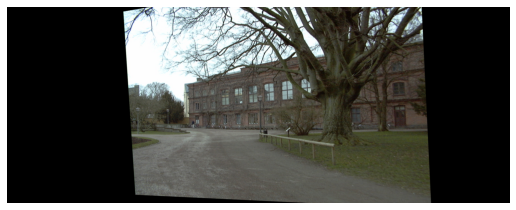

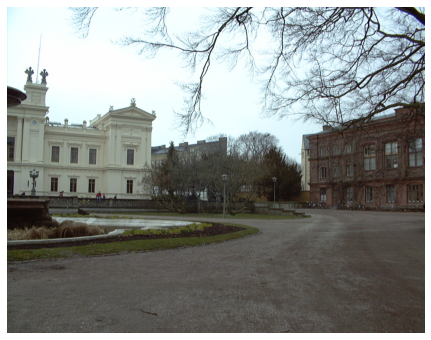

In [11]:
# 画像0を射影変換
h,w=im_list[1].shape[:2]
im_warped=cv2.warpPerspective(im_list[0],H_01,(w*2,h))
impro.imshow(im_warped)
impro.imshow(im_list[1])

確かに、0枚目の画像が、1枚目の画像に重なるように移動できている。  
なので画像の重ね合わせてみる

### 3.3.3 画像をつなぎ合わせる

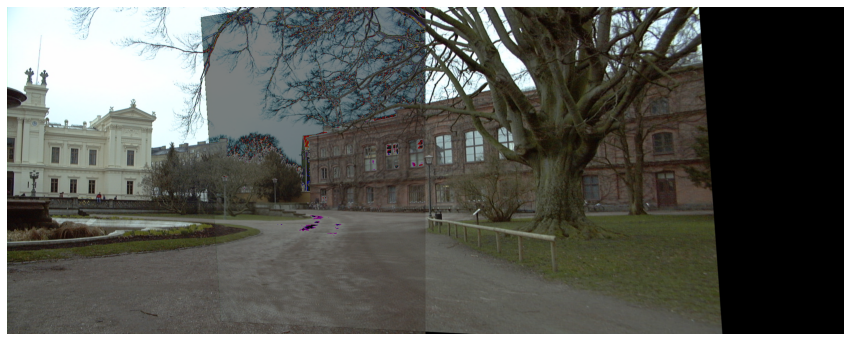

In [85]:
# 合成後用の空の画像のarrayを用意する
im_composite=np.zeros_like(im_warped)
im_composite[:,:w,:]=im_list[1]

# 1枚目の画像を保存しておく
im_paste=im_composite.copy()

# 移動後の画像がある領域のみに、張り付ける
im_warped_nonzero = im_warped.sum(axis=2)!=0
im_composite[im_warped_nonzero,:]=im_warped[im_warped_nonzero,:]

# 重なっている部分に0枚目の画像と1枚目の画像の平均値を代入する
im_overlap=im_warped_nonzero & (im_paste.sum(axis=2)!=0)
im_composite[im_overlap,:]=((im_paste[im_overlap,:]+im_warped[im_overlap,:])/2).astype(np.uint8)

impro.imshow(im_composite,figsize=(15,10))

### OpenCVでのホモグラフィー推定
`cv2.findHomography`でmthodに`cv2.RANSAC`を指定することで、RANSACによるホモグラフィー推定ができる。以下のように実装した
- 特徴点マッチングは`detection.akaze_matching`
- ホモグラフィー推定は`homography.compute_ransac_homography`
- ホモグラフィー行列による移動後の四角とマッチング結果を図に描く処理は`homography.compute_draw_homography`

参考: [特徴点のマッチングとHomographyによる物体検出 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)

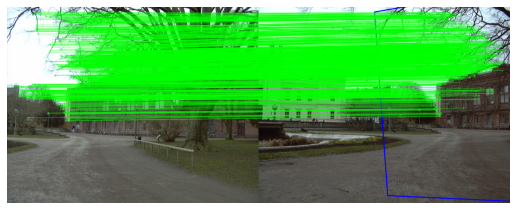

In [3]:
img_result=homography.compute_draw_homography(im_list[0],im_list[1])
impro.imshow(img_result)